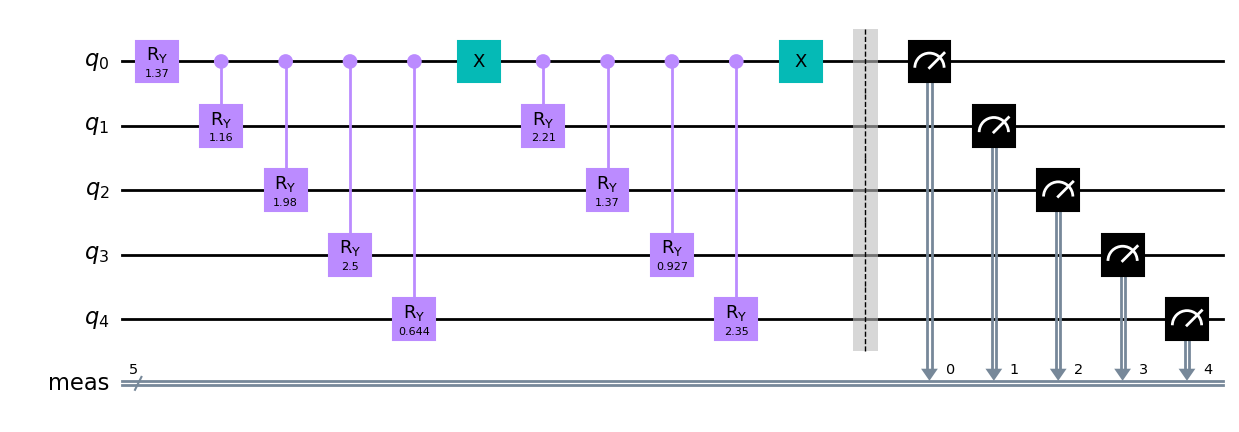

In [18]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np

# Function to calculate rotation angle
def calc_angle(prob):
    #Calculate the angle using the formula
    return 2 * np.arccos(np.sqrt(prob))

def create_quantum_circuit(null_prior, null_probs, positive_probs):
    # Calculate angles based on the provided probabilities
    theta_y = calc_angle(null_prior)
    null_rotations = [calc_angle(conditional) for conditional in null_probs]
    pos_rotations = [calc_angle(conditional) for conditional in positive_probs]
    
    # Initialize the quantum circuit with n qubits and n classical bits
    assert(len(null_probs) == len(positive_probs))
    n = len(null_probs) #Number of features
    circ = QuantumCircuit(n+1)
    
    # Implementing the gates based on the calculated thetas
    circ.ry(theta_y, 0)  # Encode P(y=0) into qubit 0
    for i in range(n):
        circ.cry(null_rotations[i], 0, i+1)
    circ.x(0)  # Flip y to represent y=1
    for i in range(n):
        circ.cry(pos_rotations[i], 0, i+1) # Now for y=1, encode P(x1|y=1)
    circ.x(0)  # Reset y back
    
    # Measure 
    circ.measure_all()  # Measure both the label and feature qubits
    
    return circ

# Example usage
P_y0 = 0.6
P_xn_given_y0 = [0.7, 0.3, 0.1, 0.9]
P_xn_given_y1 = [0.2, 0.6, 0.8, 0.15]
circ = create_quantum_circuit(P_y0, P_xn_given_y0, P_xn_given_y1)

# To draw the circuit using Matplotlib, ensure you have matplotlib installed and your environment supports plotting
circ.draw('mpl')


In [1]:
import Naive_qbc_ as nqbc
from processed_dataset import BinaryPreprocess
from qiskit import transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

import torch
import numpy as np
from PIL import Image

null_class = 0
alt_class = 1

if __name__ == "__main__":
    preproc = BinaryPreprocess([null_class, alt_class])

    #null prior, null probs, positive probs
    naive_qbc = nqbc.create_quantum_circuit(preproc.prior, preproc.null_probs.tolist(), preproc.positive_probs.tolist())    
    img = torch.from_numpy(np.array(Image.open('Haddy01.PNG').convert('L')))
    binarized_features = preproc.inference_features(img).squeeze()
    print(binarized_features)

    pre_circ = QuantumCircuit(len(preproc.null_probs)+1)
    for i in range(len(binarized_features)):
        if binarized_features[i].item() == 1:
            pre_circ.x(i+1)

    composite = pre_circ.compose(naive_qbc)
    composite.draw()
    simulator = AerSimulator()
    shots = 1024
    
    composite = transpile(composite, simulator)
    result = simulator.run(composite, shots=shots).result()
    counts = result.get_counts(composite)

    print(counts)
    matched_counts = {}
    for output in counts.keys():
        for i in range(len(binarized_features)):
            n = len(binarized_features)-1 #Output is little-endian
            if float(output[i]) != binarized_features[n-i].item():
                continue
            matched_counts[output[-1]] = counts[output]

    plot_histogram(matched_counts, title='Output Counts')
    plt.show()

tensor([0., 0., 0., 0., 1., 0., 1., 0., 0.])
{'0111100101': 1, '1111100111': 1, '0101100100': 3, '0110101110': 1, '1100100100': 1, '0110110100': 13, '0100100110': 1, '1100111111': 1, '1101100111': 2, '1111101101': 1, '0101110111': 10, '0111110100': 3, '0101101100': 1, '1110111100': 1, '1110101100': 3, '1101100101': 3, '1110110100': 1, '1101110111': 29, '0100100100': 20, '1111101111': 1, '1101110101': 70, '0111110101': 10, '0101111101': 28, '1111100100': 1, '0111111101': 12, '0101110101': 20, '0101111111': 17, '1111111111': 22, '0111111111': 4, '1101111101': 115, '1110100100': 11, '1111110111': 21, '0110110110': 1, '0101101101': 1, '0110100110': 6, '0111101100': 10, '0100101100': 2, '1111110101': 29, '0111110111': 3, '1101101101': 4, '1111101100': 1, '0111100100': 42, '0110111100': 3, '0101100111': 1, '0110101100': 66, '1111100101': 2, '1111111101': 65, '1101111111': 53, '0110100100': 307}


In [22]:
## Add Kevin's code here
import BinaryPreprocess as bp

binary_process = BinaryPreprocess()
binary


SyntaxError: invalid syntax (3089776600.py, line 4)